In [1]:
############## Imports ######################
import glob
import numpy as np;
import cv2;
from skimage.feature import hog
import os;
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pickle;
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from collections import deque

## Parameters

In [2]:
########### Parameters to tune ##############
pix_per_cell = 8
cell_per_block = 4
orient = 11

## Data Exploration

In [3]:
vehicle_images = glob.glob('./vehicles/**/*.png');
non_vehicle_images = glob.glob('./non-vehicles/**/*.png');
img = plt.imread(vehicle_images[np.random.randint(0,len(vehicle_images))]);

print('count of vehicle images : ',len(vehicle_images));
print('count of non vehicle images : ',len(non_vehicle_images));
print('Image Size : ',img.shape[:-1]);
print('Image Channel : ',img.shape[-1])

count of vehicle images :  8792
count of non vehicle images :  8968
Image Size :  (64, 64)
Image Channel :  3


## Data Visualization

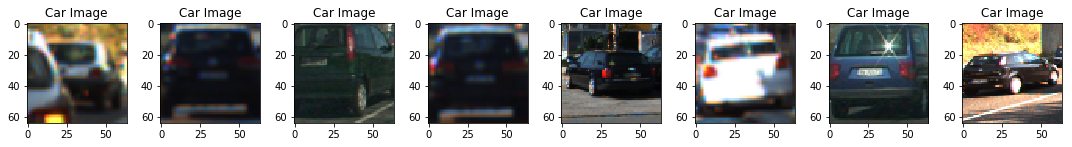

In [4]:
########### Visualizing Car Images ##############
row = 1
col = 8
plt.figure(figsize=(15,6))

for i in range(0,row*col):
    img = plt.imread(vehicle_images[np.random.randint(0,len(vehicle_images))]);
    plt.subplot(row,col,i+1);
    plt.title("Car Image");
    plt.imshow(img);
plt.tight_layout()
plt.show();

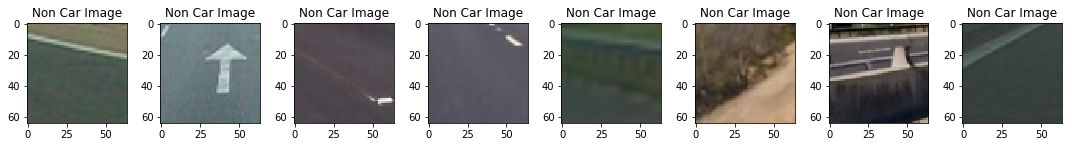

In [5]:
########### Visualizing Non Car Images #############
row = 1
col = 8
plt.figure(figsize=(15,6))

for i in range(0,row*col):
    img = plt.imread(non_vehicle_images[np.random.randint(0,len(non_vehicle_images))]);
    plt.subplot(row,col,i+1);
    plt.title("Non Car Image");
    plt.imshow(img);
plt.tight_layout()
plt.show();

## Histogram of Oriented Gradients (HOG)

In [6]:
############## Methods for HOG feauture Extraction ##############

def extract_HOG_features(img,vis=False,feature_vector=True):
    
    if(vis==True):
        hog_features, hog_image = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=feature_vector,transform_sqrt=True,
                          block_norm="L2-Hys");
        return hog_features,hog_image;
    else:
        hog_features = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block),transform_sqrt=True,
                          visualise=False, feature_vector=feature_vector,
                          block_norm="L2-Hys");
        return hog_features;

Features size :  4400


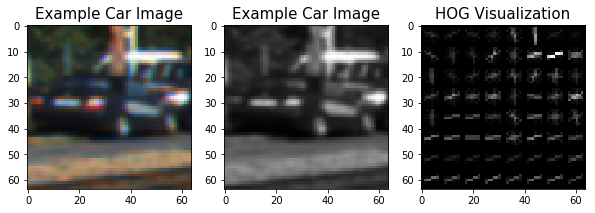

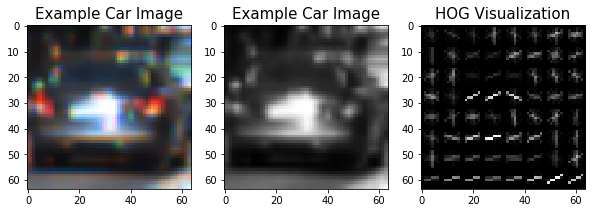

In [7]:
def test_hog_feture_extraction():
  
    for i in range(0,2):
        image = plt.imread(vehicle_images[np.random.randint(0,len(vehicle_images))]);
        y_img = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)[:,:,0]
        hog_feature,vis_img=extract_HOG_features(y_img,vis=True);
        # Plot the examples
        fig = plt.figure(figsize=(10,10))
        plt.subplot(131)
        plt.imshow(image)
        plt.title('Example Car Image',fontsize=15)
        plt.subplot(132)
        plt.imshow(y_img, cmap='gray')
        plt.title('Example Car Image',fontsize=15)
        plt.subplot(133)
        plt.imshow(vis_img, cmap='gray')
        plt.title('HOG Visualization',fontsize=15);
    print("Features size : ",hog_feature.shape[0]);

test_hog_feture_extraction();

In [8]:
#############################################################
#####            Features Extraction                    #####
#############################################################

def extract_features(file_names):
    features = [];
    for file_name in file_names:
        img=plt.imread(file_name);
        if(img.shape[-1]==3):
            y_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:,:,0]; # using Y-Channel of YUV Color space
        else:
            y_img  = img;
        hog_features = extract_HOG_features(y_img,vis=False,feature_vector=True);
        features.append(hog_features);
        #features.append(extract_color_features(img));
    return features;

## Feature Extraction

In [9]:
# print("Features Extraction Started.....")
# start_time = time.time();
# #------------------------Start-----------------------------
# vehicle_features = extract_features(vehicle_images);
# non_vehicle_features = extract_features(non_vehicle_images)
# #------------------------End-------------------------------
# end_time = time.time();

# print("Total time to extarct features :  ",end_time-start_time,"sec")

## Data Split

In [10]:
def split():
    features = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64);
    labels = np.hstack((np.ones(len(vehicle_features)),np.zeros(len(non_vehicle_features))));

    #### Splitting training and test data ####
    features_train, features_test, labels_train, labels_test = train_test_split(
        features, labels, test_size=0.2)

    x_scaler = StandardScaler().fit(features_train);
    features_train = x_scaler.transform(features_train);
    
    
    return features_train, features_test, labels_train, labels_test ,x_scaler
    


## Saving model

In [11]:
def save_model(model_file_path):
    with open(model_file_path,'wb') as model_file:
        pickle.dump({'clf':clf,'x_scaler':x_scaler},model_file);
    print("Model Saved..")

## Cheking test accuracy

In [12]:
def check_accuracy(features_test,labels_test,x_scaler):
    features_test = x_scaler.transform(features_test);
    test_score = clf.score(features_test,labels_test);
    return test_score*100


## Classifier Training

In [13]:
model_file_path= './model.pickle';
def train():
    if(os.path.exists(model_file_path)):
        print("loading from the model file...")
        with open(model_file_path,'rb') as model_file:
            model=pickle.load(model_file);
        print("model file loaded.");
        return model['clf'],model['x_scaler'];
    
    features_train, features_test, labels_train, labels_test ,x_scaler = split();
    print("Training Data Size : ",features_train.shape)
    print("Testing Data Size : ",features_test.shape)
    print("Training Started.....")
    start_time = time.time();
    #------------------------Start-----------------------------
    clf = SVC(kernel="rbf",C=86)
    # param_dict = {'C':np.random.uniform(1,100,200)}
    # clf = RandomizedSearchCV(estimator=clf,param_distributions=param_dict,n_iter=10);
    clf.fit(features_train,labels_train);
    #------------------------End-------------------------------
    end_time = time.time();
    total_time = end_time-start_time;
    print("Total time to Train Classifier :  ",total_time,"sec");
    check_accuracy(features_test,labels_test,x_scaler);
    print("Test Accuracy of Classfier : ",test_score," %");
    # print("Best params : ", clf.best_params_)
    save_model(model_file_path)
    return clf,x_scaler;

clf,x_scaler = train();

loading from the model file...
model file loaded.


In [14]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    draw_img = np.copy(img)
    for box in bboxes:
        cv2.rectangle(draw_img,box[0],box[1],color,thick);
    return draw_img 

In [15]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, clf, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:];
#     plt.imshow(img_tosearch);
#     plt.show();
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)  
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace Y channel for HOG 
    ch1 = ctrans_tosearch[:,:,0]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)- cell_per_block +1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block+1  #-1 
    
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)- cell_per_block+1 
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step+1;
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step+1;
    
#     print(nysteps);
    
    # Compute individual channel HOG features for the entire image
    hog1 = extract_HOG_features(ch1,feature_vector=False)   
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            hog_features = (hog_features).reshape(1,-1);
            hog_scalar = x_scaler.transform(hog_features)
            test_prediction = clf.predict(hog_scalar)
            
            if test_prediction == 1 :
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

In [16]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
hog_channel = '0' # Can be 0, 1, 2, or "ALL"

rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, clf, None, 11, 8, 4, None, None)

print(len(rectangles), 'rectangles found in image')

48 rectangles found in image


## Heat Map

In [17]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [18]:
def heatmap_to_rgb(heatmap):
    minn, maxx = np.amin(heatmap), np.amax(heatmap)
    normalized_heatmap = (heatmap - minn) / (maxx - minn)
  
    colormap = plt.get_cmap('hot') 
    rgba = colormap(normalized_heatmap) *255
  
    r, g, b = rgba[:, :, 0], rgba[:, :, 1], rgba[:, :, 2]
    rgb = np.dstack((r, g, b))
  
    return rgb

In [19]:
heatmap_history = deque(maxlen=7);

def process_img(img):
    rectangles_all  = [];
    window_sizes = [64,80, 120, 150, 180]
    strip_y_start = [400,400, 400, 410, 410]
    heat = np.zeros_like(img[:,:,0]).astype(np.float);
    
    for i in range(0,len(window_sizes)):
        rectangles = find_cars(img,strip_y_start[i] , strip_y_start[i]+window_sizes[i], window_sizes[i]/64, colorspace, hog_channel, clf, None, 11, 8, 4, None, None);
        for rectangle in rectangles:
            rectangles_all.append(rectangle);
        # Add heat to each box in box list
        heat = add_heat(heat,rectangles)
#         heatmap = heat;
    # Apply threshold to help remove false positives
    heatmap = apply_threshold(heat,5);
    
    heatmap_history.append(heatmap);
    heatmap = np.array(heatmap_history).sum(axis=0);
    hist_thresh = len(heatmap_history);
    heatmap = apply_threshold(heatmap,hist_thresh)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heatmap, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels);
    
    heatmap_rgb = heatmap_to_rgb(heatmap);
    heatmap_rgb = cv2.resize(heatmap_rgb,(int(0.2*draw_img.shape[1]),int(0.2*draw_img.shape[0])));
    draw_img[0:int(draw_img.shape[0]*0.2),0:int(draw_img.shape[1]*0.2)] = draw_img[0:int(draw_img.shape[0]*0.2),0:int(draw_img.shape[1]*0.2)]*0.2 + heatmap_rgb*0.8;
    
    return draw_img,heatmap,rectangles_all;

def process_video_frame(img):
    draw_img,heatmap,_ = process_img(img);
    
    return draw_img;

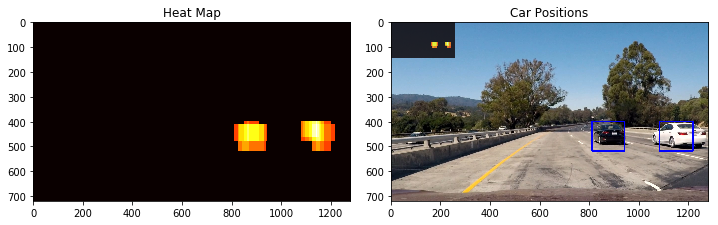

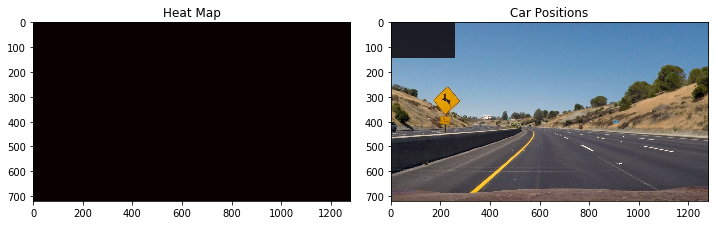

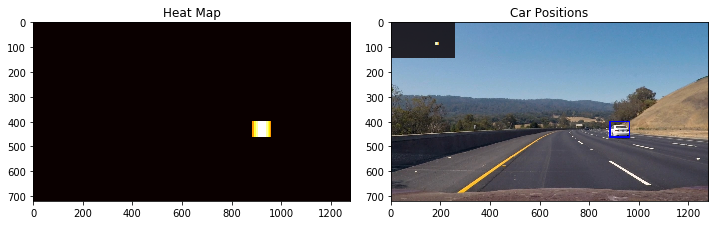

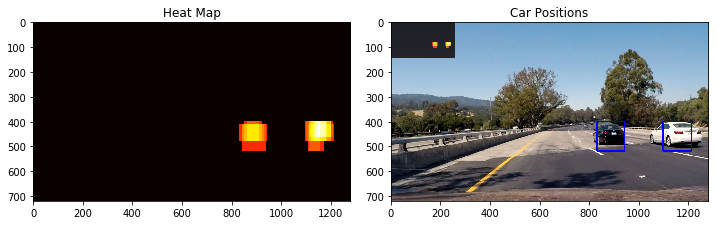

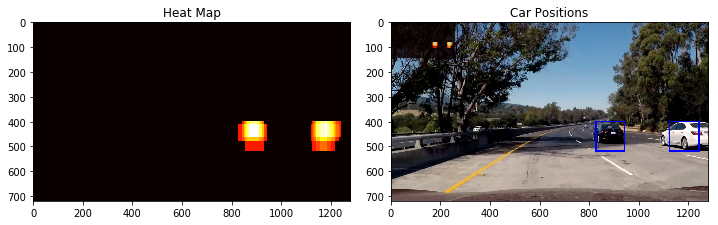

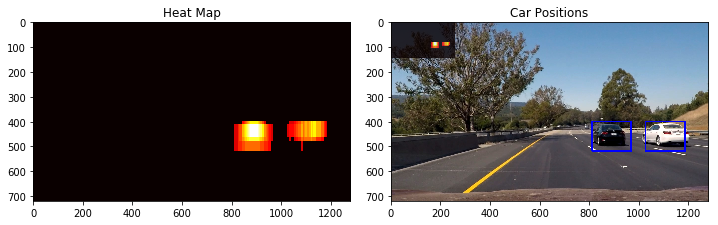

In [20]:
test_img_path = './test_images/';
for file in os.listdir(test_img_path):
    test_img = mpimg.imread(test_img_path+file);
    draw_img,heatmap,rec = process_img(test_img);
    # print(len(rec))
    # rec = np.asarray(rec).reshape(-1,4);
    # print(type(rec))
    # print(rec.shape)
    fig = plt.figure(figsize=(15,10))
    # plt.subplot(131)
    # plt.title('Rectangles')
    # plt.imshow(draw_boxes(test_img,rec));
    plt.subplot(131)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    plt.subplot(132)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    fig.tight_layout()
    heatmap_history.clear();
    plt.show();

In [21]:
# test_img_path = './ip_frames/';
# img_to_test = ['9.jpg','25.jpg'];
# for file in img_to_test:
#     test_img = mpimg.imread(test_img_path+file);
#     print(test_img.shape)
#     test_img=test_img[:,:,:3];
#     print(test_img.shape)
#     draw_img,heatmap,rec = process_img(test_img);
#     # print(len(rec))
#     # rec = np.asarray(rec).reshape(-1,4);
#     # print(type(rec))
#     # print(rec.shape)
#     fig = plt.figure(figsize=(25,10))
#     # plt.subplot(131)
#     # plt.title('Rectangles')
#     # plt.imshow(draw_boxes(test_img,rec));
#     plt.subplot(131)
#     plt.imshow(heatmap, cmap='hot')
#     plt.title('Heat Map')
#     plt.subplot(132)
#     plt.imshow(draw_img)
#     plt.title('Car Positions')
#     fig.tight_layout()
#     heatmap_history.clear();
#     plt.show();

In [22]:
ip_frames_folder = 'ip_frames'
op_frames_folder = 'op_frames'
def clear_frame_folders(ip_frames_folder,op_frames_folder):
    global frame_count;
    frame_count=0;
    if(os.path.exists(ip_frames_folder)):
        for file in os.listdir(ip_frames_folder):
            os.remove(os.path.join(ip_frames_folder,file));
        os.rmdir(ip_frames_folder);
    os.mkdir(ip_frames_folder);
    if(os.path.exists(op_frames_folder)):
        for file in os.listdir(op_frames_folder):
            os.remove(os.path.join(op_frames_folder,file));    
        os.rmdir(op_frames_folder);
    os.mkdir(op_frames_folder);
    
def process_n_save_frames(image):
    global frame_count;
    plt.imsave(ip_frames_folder+"/"+str(frame_count)+".jpg",image);
    op_image = process_video_frame(image);
    plt.imsave(op_frames_folder+"/"+str(frame_count)+".jpg",op_image);
    frame_count+=1;
    return op_image;

In [23]:
def run_on_video(path):
    output = 'test_videos_output/output_project.mp4'
    try:
        ip_frames_folder = 'ip_frames'
        op_frames_folder = 'op_frames'
        clear_frame_folders(ip_frames_folder,op_frames_folder);
#         clip = VideoFileClip(path).subclip(28,31);
        clip = VideoFileClip(path);
        print("Processing Video..");
#         out_clip = clip.fl_image(process_n_save_frames);
        out_clip = clip.fl_image(process_video_frame);
        out_clip.write_videofile(output, audio=False)
    finally:
        clip.reader.close();
        

In [24]:
input_video_path='./project_video.mp4'
run_on_video(input_video_path);

Processing Video..
[MoviePy] >>>> Building video test_videos_output/output_project.mp4
[MoviePy] Writing video test_videos_output/output_project.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:29:31<00:03,  3.73s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/output_project.mp4 

